In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADCLOUD_MODEL_STATE_DICT_PATH=os.getenv("RADCLOUD_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radcloud_encoder import RadCloudEncoder
from mmwave_model_integrator.ground_truth_encoders.radcloud_gt_encoder import RadCloudGTEncoder
from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.dataset_generators.rng_az_to_pc_dataset_generator import RngAzToPCDatasetGenerator

/home/david/.cache/pypoetry/virtualenvs/mmwave-model-integrator-S4Y7oiM5-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#setup the config manager
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadCloud_original.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#determine the paths to all of the datasets
dataset_groups = ["ugv_seen_dataset","ugv_unseen_dataset","ugv_rapid_movement_dataset"]

train_scenario_folders = []
test_scenario_folders = []

for group in dataset_groups:
    group_path = os.path.join(MODEL_TRAINING_DATASET_PATH,"RadCloud",group)
    entries = sorted(os.listdir(group_path))
    for entry in entries:
        path = os.path.join(group_path,entry)
        if os.path.isdir(path):
            if 'test' in entry.lower():
                test_scenario_folders.append(path)
            else:
                train_scenario_folders.append(path)

In [4]:
#initializing the dataset generator
dataset_path = train_scenario_folders[0]
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 12080 radar samples
found 12080 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples
did not find vehicle odometry samples


In [5]:
#initialize the encoder and decoder
input_encoder = RadCloudEncoder(
    config_manager=cfg_manager,
    max_range_bin=64,
    num_chirps_to_encode=1,
    radar_fov_rad= [-0.87,0.87],
    num_az_angle_bins=64,
    power_range_dB=[60,105]
)

ground_truth_encoder = RadCloudGTEncoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(50),np.deg2rad(-50)],
    num_angle_bins=48,
    num_previous_frames=0
)

plotter = PlotterRngAzToPC()

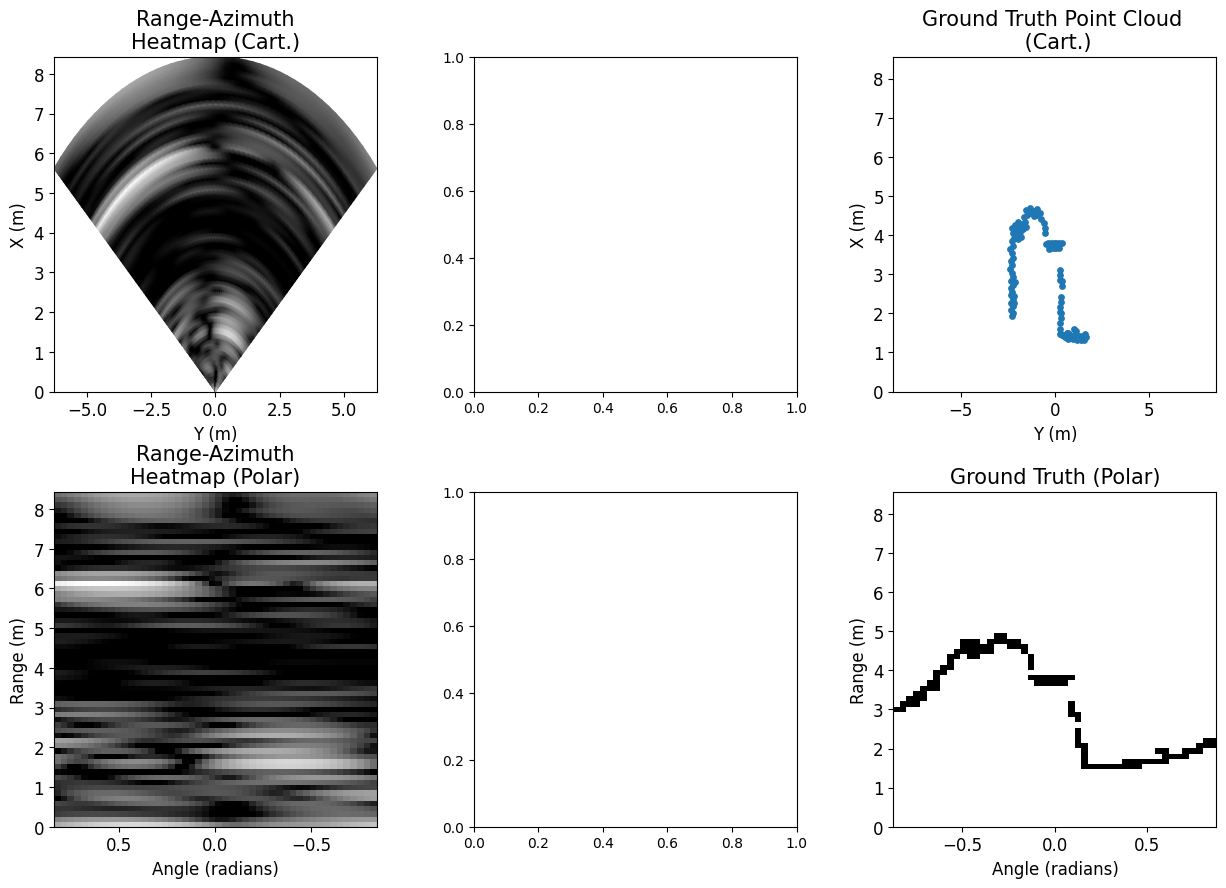

In [6]:
#plot a sample of the input/output for training
adc_cube = dataset.get_radar_data(idx=0)

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx=0)

plotter.plot_compilation(
    input_data=adc_cube,
    input_encoder=input_encoder,
    gt_data=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    axs=[],
    show=True
)

In [ ]:
#initialize the dataset generator
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadCloud_train")
dataset_generator = RngAzToPCDatasetGenerator(
    generated_dataset_path=generated_dataset_path,
    dataset_handler=dataset,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    generated_file_name="frame",
    input_encoding_folder="x_s",
    ground_truth_encoding_folder="y_s",
    clear_existing_data=True
)

In [ ]:
#generate the training dataset
dataset_generator.generate_dataset_from_multiple_scenarios(train_scenario_folders)

In [ ]:
#generating the testing dataset
# generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadCloud_test")
# dataset_generator.reset(generated_dataset_path)
# dataset_generator.generate_dataset_from_multiple_scenarios(test_scenario_folders)


In [7]:
from mmwave_model_integrator.config import Config
# config_path = "../configs/radcloud_single_chirp.py"
config_path = "../configs/radcloud_single_chirp_for_radsar_transfer.py"
config = Config(config_path)

config.print_config()

model=dict(
    type=RadCloudUnet,
    encoder_input_channels=1,
    encoder_out_channels=(64, 128, 256),
    decoder_input_channels=(512, 256, 128),
    decoder_out_channels=64,
    output_channels=1,
    retain_dimmension=False,
    input_dimmensions=(96, 88),
),
generated_dataset=dict(
    input_encoding_folder=x_s,
    ground_truth_encoding_folder=y_s,
    generated_dataset_path=/home/david/Downloads/generated_datasets/RadCloud_train,
),
trainer=dict(
    type=_BaseTorchTrainer,
    model=dict(
        type=RadCloudUnet,
        encoder_input_channels=1,
        encoder_out_channels=(64, 128, 256),
        decoder_input_channels=(512, 256, 128),
        decoder_out_channels=64,
        output_channels=1,
        retain_dimmension=False,
        input_dimmensions=(96, 88),
    ),
    optimizer=dict(
        type=Adam,
        lr=0.001,
    ),
    dataset=dict(
        type=_BaseTorchDataset,
        input_transforms=[{'type': 'RandomRadarNoise', 'noise_level': 0.25}, {'type': 'ToTen

In [8]:
import mmwave_model_integrator.torch_training.trainers as trainers

trainer_config = config.trainer
trainer_class = getattr(trainers,trainer_config.pop('type'))
trainer = trainer_class(**trainer_config)


ModelTrainer: 70787 train, 12492 val samples loaded
_BaseTorchTrainer._check_for_directory: found directory working_dir


In [9]:
#train the model
trainer.train_model()

ModelTrainer.train: training the network...


 10%|█         | 1/10 [12:55<1:56:23, 775.92s/it]

EPOCH: 1/10
	 Train loss: 0.22790329158306122, Val loss:0.19834354519844055


 20%|██        | 2/10 [25:52<1:43:28, 776.07s/it]

EPOCH: 2/10
	 Train loss: 0.18908648192882538, Val loss:0.18912389874458313


 30%|███       | 3/10 [38:51<1:30:44, 777.73s/it]

EPOCH: 3/10
	 Train loss: 0.18132777512073517, Val loss:0.19546890258789062


 40%|████      | 4/10 [51:51<1:17:51, 778.56s/it]

EPOCH: 4/10
	 Train loss: 0.1751735657453537, Val loss:0.17590926587581635


 50%|█████     | 5/10 [1:04:51<1:04:55, 779.03s/it]

EPOCH: 5/10
	 Train loss: 0.16933998465538025, Val loss:0.18174390494823456


 60%|██████    | 6/10 [1:17:51<51:57, 779.32s/it]  

EPOCH: 6/10
	 Train loss: 0.16390548646450043, Val loss:0.1767875999212265


 70%|███████   | 7/10 [1:30:51<38:58, 779.51s/it]

EPOCH: 7/10
	 Train loss: 0.15912644565105438, Val loss:0.16612021625041962


 80%|████████  | 8/10 [1:43:51<25:59, 779.68s/it]

EPOCH: 8/10
	 Train loss: 0.1530560404062271, Val loss:0.16121648252010345


 90%|█████████ | 9/10 [1:56:51<12:59, 779.77s/it]

EPOCH: 9/10
	 Train loss: 0.14814706146717072, Val loss:0.16065613925457


100%|██████████| 10/10 [2:09:51<00:00, 779.14s/it]

EPOCH: 10/10
	 Train loss: 0.1431620568037033, Val loss:0.1529359221458435
ModelTrainer.train: total training time 7791.37
